# Art Style Transfer

This notebook is an implementation of the algorithm described in "A Neural Algorithm of Artistic Style" (http://arxiv.org/abs/1508.06576) by Gatys, Ecker and Bethge. Additional details of their method are available at http://arxiv.org/abs/1505.07376 and http://bethgelab.org/deepneuralart/.

An image is generated which combines the content of a photograph with the "style" of a painting. This is accomplished by jointly minimizing the squared difference between feature activation maps of the photo and generated image, and the squared difference of feature correlation between painting and generated image. A total variation penalty is also applied to reduce high frequency noise. 

In [5]:
import theano
import theano.tensor as T

import lasagne
from lasagne.utils import floatX

import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import time

In [6]:
from model import googlenet

net = googlenet.build_model()
net_input_var = net['input'].input_var
net_output_layer = net['prob']


Load the pretrained weights into the network :

In [7]:
params = pickle.load(open('./data/googlenet/blvc_googlenet.pkl'))
model_param_values = params['param values']
#classes = params['synset words']
lasagne.layers.set_all_param_values(net_output_layer, model_param_values)

IMAGE_W=224
print("Loaded Model parameters")

Loaded Model parameters


### Choose the Photo to be *Enhanced*


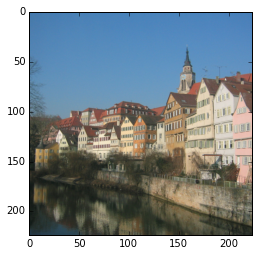

In [8]:
photo = plt.imread('./images/art-style/Tuebingen_Neckarfront.jpg')
rawim, photo = googlenet.prep_image(photo)
plt.imshow(rawim)

### Choose the photo with the required 'Style'

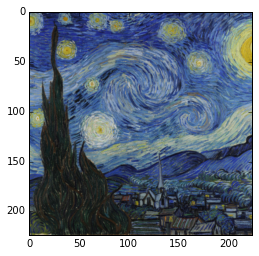

In [9]:
art = plt.imread('./images/art-style/960px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
rawim, art = googlenet.prep_image(art)
plt.imshow(rawim)

This defines various measures of difference that we'll use to compare the current output image with the original sources.

In [10]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g

def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss

def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

Here are the GoogLeNet layers that we're going to pay attention to :

In [ ]:
layers = [
    # used for 'content' in photo - a mid-tier convolutional layer 
    'inception_4b/output', 
    
    # used for 'style' - conv layers throughout model (not same as content one)
    'conv1/7x7_s2', 'conv2/3x3', 'inception_3b/output', 'inception_4d/output',
]
#layers = [
#    # used for 'content' in photo - a mid-tier convolutional layer 
#    'pool4/3x3_s2', 
#    
#    # used for 'style' - conv layers throughout model (not same as content one)
#    'conv1/7x7_s2', 'conv2/3x3', 'pool3/3x3_s2', 'inception_5b/output',
#]
layers = {k: net[k] for k in layers}

### Precompute layer activations for photo and artwork 
This takes ~ 20 seconds

In [ ]:
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

photo_features = {k: theano.shared(output.eval({input_im_theano: photo}))
                  for k, output in zip(layers.keys(), outputs)}
art_features = {k: theano.shared(output.eval({input_im_theano: art}))
                for k, output in zip(layers.keys(), outputs)}

In [ ]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

### Define the overall loss / badness function

In [ ]:
losses = []

# content loss
cl = 10 /1000.
losses.append(cl * content_loss(photo_features, gen_features, 'inception_4b/output'))

# style loss
sl = 20 *1000.
losses.append(sl * style_loss(art_features, gen_features, 'conv1/7x7_s2'))
losses.append(sl * style_loss(art_features, gen_features, 'conv2/3x3'))
losses.append(sl * style_loss(art_features, gen_features, 'inception_3b/output'))
losses.append(sl * style_loss(art_features, gen_features, 'inception_4d/output'))
#losses.append(sl * style_loss(art_features, gen_features, 'inception_5b/output'))

# total variation penalty
vp = 0.01 /1000. /1000.
losses.append(vp * total_variation_loss(generated_image))

total_loss = sum(losses)

### The *Famous* Symbolic Gradient operation

In [ ]:
grad = T.grad(total_loss, generated_image)

### Get Ready for Optimisation by SciPy

In [ ]:
# Theano functions to evaluate loss and gradient - takes around 1 minute (!)
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

Initialize with a noise image

In [ ]:
generated_image.set_value(photo)
#generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGE_W, IMAGE_W))))

x0 = generated_image.get_value().astype('float64')
iteration=0

### Optimize all those losses, and show the image

To refine the result, just keep hitting 'run' on this cell (each iteration is about 60 seconds) :

In [ ]:
t0 = time.time()

scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40) 

x0 = generated_image.get_value().astype('float64')
iteration += 1

plt.figure(figsize=(8,8))
plt.imshow(googlenet.deprocess(x0), interpolation='nearest')
plt.axis('off')
plt.text(270, 25, '# {} in {:.1f}sec'.format(iteration, (float(time.time() - t0))), fontsize=14)
